In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display, clear_output
from colorsys import hls_to_rgb
from PIL import Image
import os
import glob

# System parameters

In [11]:
# size of the region of interest
roi_size_px = 332*2
# wavelength of acquisition
lambda_m = 13.5e-9

# effective pixel size
dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m

# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

# angular frequency scale
fs = 1 / (x_m[1] - x_m[0])
Nfft = len(x_m)
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2

# frequency cut-off of the lens (0.33 4xNA lens)
fc_lens = (np.arcsin(.33/4)/lambda_m)
# lens pupil filter in reciprocal space
Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
FILTER = (Fx**2 + Fy**2) <= fc_lens**2

# Helper functions

In [12]:
# centered Fourier Transform
ft = lambda signal: np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(signal)))
ift = lambda signal: np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(signal)))

# circular shifting
def circshift2(input, x_shift_px, y_shift_px):
    return np.roll(np.roll(input, round(x_shift_px), axis=1), round(y_shift_px), axis=0)

def colorize(z):
    n,m = z.shape
    c = np.zeros((n,m,3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2*np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0 - 1.0/(1.0+abs(z[idx])**0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a,b in zip(A,B)]
    return c

def imagecc(img_complex):
    '''
    imagecc(img_complex) displays an image where amplitude is mapped
    on the value and the phase is mapped on the hue.
    img_rgb =imagecc(img_complex) returns the corresponding RGB data,
    '''

    N_row, N_col = img_complex.shape

    map_func = lambda x, channel: np.minimum(6*np.mod(x-(channel+1)/3,1),1) * \
        np.maximum(np.minimum(6*(2/3-np.mod(x-(channel+1)/3,1)),1),0)

    img_abs = np.abs(img_complex.ravel())/(np.max(np.abs(img_complex.ravel())))
    img_arg = np.angle(img_complex.ravel())/(2*np.pi)+0.5

    img_rgb = np.zeros((N_row,N_col,3))

    img_rgb[:,:,0] = np.reshape(map_func(img_arg,1)*np.abs(img_abs),(N_row,N_col))
    img_rgb[:,:,1] = np.reshape(map_func(img_arg,2)*np.abs(img_abs),(N_row,N_col))
    img_rgb[:,:,2] = np.reshape(map_func(img_arg,3)*np.abs(img_abs),(N_row,N_col))

    return img_rgb

# Metric function
Implement the Fourier Ring Correlation in http://doi.org/10.1038/nmeth.2448

In [13]:
def circsum(img_in):
    if img_in.shape[0] != img_in.shape[1]:
        raise ValueError('the input matrix must be square')

    N_px = img_in.shape[0]
    xc = yc = N_px // 2

    X, Y = np.meshgrid(np.arange(N_px), np.arange(N_px))
    dcirc = np.zeros(N_px//2, dtype=complex)
    for i in range(N_px//2):
        domain = ((X-xc)**2+(Y-yc)**2 >= i**2) & ((X-xc)**2+(Y-yc)**2 < (i+1)**2)
        dcirc[i] = np.sum(domain * img_in)

    return dcirc

def frc(img1, img2):
    ft1 = ft(img1)
    ft2 = ft(img2)

    frc_array = circsum(ft1 * np.conj(ft2)) / (np.sqrt(circsum(np.abs(ft1)**2)) * np.sqrt(circsum(np.abs(ft2)**2)))

    n_vox = np.sum(np.ones(img1.shape))
    halfbit_threshold = (0.2071 + 1.9102 / np.sqrt(n_vox)) / (1.2071 + 0.9102 / np.sqrt(n_vox))

    return frc_array, halfbit_threshold

# Load data

In [14]:
# Folder containing the images
folder = './real_data/enlarged_defect/' # specify your folder

# Find all .png files in the folder
files = glob.glob(os.path.join(folder, "*.png"))

img = []
sx = []
sy = []
for filename in files:
    img.append(np.array(Image.open(filename)))
    filename = os.path.basename(filename)
    # sx.append(float(filename[-20:-15]))
    sx.append(float(filename[-17:-12]))
    sy.append(float(filename[-9:-4]))

print(len(img))

81


# Initialization

In [15]:
# Load Ground truth aberration if available
# aberrated_FILTER = np.load('./sim_data/pupil_function.npy')
aberrated_FILTER = FILTER

spectrum_guess = ift(np.sqrt(img[0]))
spectrum_guess = spectrum_guess * FILTER
object_guess = ft(spectrum_guess)
lens_guess = np.double(FILTER)

# G-S

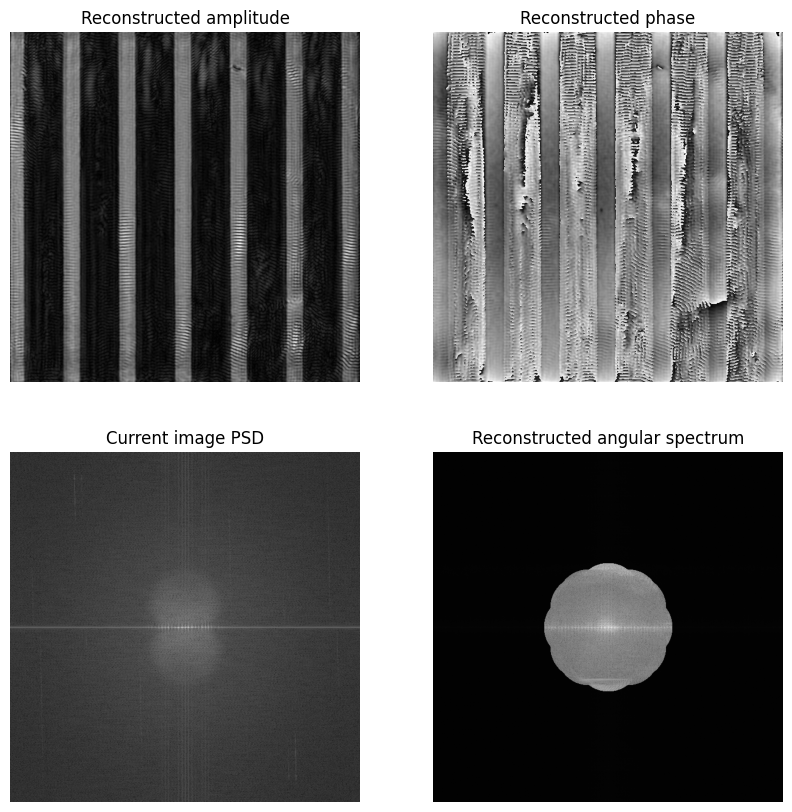

In [16]:
N_img = len(img) # assuming img is a list

for k in range(3): # general loop
    for i in range(N_img):
        idx = i

        S_n = object_guess
        S_p = ft(S_n)

        X0 = round(sx[idx]*fc_lens*Dx_m)
        Y0 = round(sy[idx]*fc_lens*Dx_m)

        mask = circshift2(FILTER, X0, Y0)
        aberrated_mask = circshift2(aberrated_FILTER, X0, Y0)
        phi_n = aberrated_mask * S_p

        Phi_n = ift(phi_n)
        Phi_np = np.sqrt(img[idx]) * np.exp(1j*np.angle(Phi_n))
        phi_np = ft(Phi_np) # undo aberration

        # S_p[mask] = phi_np[mask]
        step = np.conj(aberrated_mask)/np.max(np.abs(aberrated_mask)**2)*(phi_np-phi_n)
        S_p[mask] = S_p[mask] + step[mask]
        S_np = ift(S_p)
        object_guess = S_np

        plt.figure(figsize=(10,10)) # create a new figure in each iteration

        plt.subplot(221)
        plt.imshow(np.abs(object_guess), cmap=cm.gray)
        plt.title('Reconstructed amplitude')
        plt.axis('off')

        plt.subplot(222)
        plt.imshow(np.angle(object_guess), cmap=cm.gray)
        plt.axis('off')
        plt.title('Reconstructed phase')

        plt.subplot(223)
        plt.imshow(np.abs(ft(img[idx]))**0.1, cmap=cm.gray)
        plt.title('Current image PSD')
        plt.axis('off')

        plt.subplot(224)
        plt.imshow(np.abs(ft(S_np))**0.1, cmap=cm.gray)
        plt.title('Reconstructed angular spectrum')
        plt.axis('off')

        display(plt.gcf()) # display the current figure
        clear_output(wait = True) # clear the output of the current cell receiving output
        plt.pause(0.01) # pause for a short time


In [ ]:
plt.imshow(np.abs(object_guess)**2, extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('Reconstructed image')
plt.colorbar()
plt.show()

# Compare with ground truth

In [ ]:
obj_lines = np.load('obj_lines.npy')

plt.figure(figsize=(12, 8))  # Increase the figure size

plt.subplot(221)
plt.imshow(np.abs(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)', fontsize=10)
plt.ylabel('y position (nm)', fontsize=10)
plt.title('Reconstructed amplitude', fontsize=12)

plt.subplot(222)
plt.imshow(np.angle(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)', fontsize=10)
plt.ylabel('y position (nm)', fontsize=10)
plt.title('Reconstructed phase', fontsize=12)

plt.subplot(223)
plt.imshow(np.abs(obj_lines), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)', fontsize=10)
plt.ylabel('y position (nm)', fontsize=10)
plt.title('Ground truth amplitude', fontsize=12)

plt.subplot(224)
plt.imshow(np.angle(obj_lines), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)', fontsize=10)
plt.ylabel('y position (nm)', fontsize=10)
plt.title('Ground truth phase', fontsize=12)

plt.subplots_adjust(wspace=0.5, hspace=0.3)  # Increase space between subplots
plt.tight_layout()  # Automatically adjust subplot parameters for better fit
plt.show()


In [ ]:
obj_lines = np.load('obj_lines.npy')
ideal_FILTER = (Fx**2 + Fy**2) <= ((2)*fc_lens)**2
object_gt = ift(ft(obj_lines)*ideal_FILTER)

plt.figure(figsize=(10, 10))  # Increase the figure size

plt.subplot(121)
plt.imshow(imagecc(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)', fontsize=10)
plt.ylabel('y position (nm)', fontsize=10)
plt.title('Reconstructed object', fontsize=12)

plt.subplot(122)
plt.imshow(imagecc(object_gt), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)', fontsize=10)
plt.ylabel('y position (nm)', fontsize=10)
plt.title('Ground truth object (bandlimited)', fontsize=12)


plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Increase space between subplots
plt.tight_layout()  # Automatically adjust subplot parameters for better fit
plt.show()

In [ ]:
# normalization
plt.figure()
im_guess = np.abs(object_guess)**2
im_gt = np.abs(object_gt)**2
im_guess_normalized = im_guess / np.std(im_guess)
im_gt_normalized = im_gt / np.std(im_gt)

plt.figure()
plt.plot(x_m*1e9, np.abs(im_guess_normalized[160,:]))
plt.plot(x_m*1e9, np.abs(im_gt_normalized[160,:]))
plt.title('Slice 160')
plt.xlabel('x position (nm)')
plt.ylabel('normalized intensity (a.u.)')
plt.legend(['image guess', 'ground truth'])
plt.show()

rmse_normalized = np.sqrt(np.sum((im_guess_normalized-im_gt_normalized)**2))/np.sqrt(np.sum(im_gt_normalized**2))
print(np.log(rmse_normalized))

frc_array, halfbit_threshold = frc(im_guess_normalized, im_gt_normalized)
plt.figure()
plt.plot(freq_cpm[roi_size_px//2:], np.abs(frc_array))
plt.axhline(halfbit_threshold, color='r', linestyle='--', label='Half-bit threshold')
plt.title('Fourier ring correlation')
plt.xlabel('Spatial frequency (nm-1)')
plt.legend()
plt.show()

In [ ]:
# normalization
plt.figure()
im_guess = np.abs(object_guess)**2
im_gt = np.abs(object_gt)**2
im_guess_normalized = im_guess / np.std(im_guess)
im_gt_normalized = im_gt / np.std(im_gt)

plt.figure()
plt.plot(x_m*1e9, np.abs(im_guess_normalized[160,:]))
plt.plot(x_m*1e9, np.abs(im_gt_normalized[160,:]))
plt.title('Slice 160')
plt.xlabel('x position (nm)')
plt.ylabel('normalized intensity (a.u.)')
plt.legend(['image guess', 'ground truth'])
plt.show()

img1 = im_gt_normalized + 0.1*np.random.random((roi_size_px, roi_size_px))
img2 = im_gt_normalized + 0.1*np.random.random((roi_size_px, roi_size_px))

rmse_normalized = np.sqrt(np.sum((im_guess_normalized-im_gt_normalized)**2))/np.sqrt(np.sum(im_gt_normalized**2))
print(np.log(rmse_normalized))

frc_array, halfbit_threshold = frc(img1, img2)
plt.figure()
plt.plot(freq_cpm[roi_size_px//2:], np.abs(frc_array))
plt.axhline(halfbit_threshold, color='r', linestyle='--', label='Half-bit threshold')
plt.title('Fourier ring correlation')
plt.xlabel('Spatial frequency (nm-1)')
plt.legend()
plt.show()

# EPFR

## Initialize with a good guess

In [ ]:
def zernike_polynomial(n, m, pupil):
    def polar_coords():
        """Generate polar coordinates for a given size"""
        x = np.linspace(-1, 1, cmax-cmin+1)
        y = np.linspace(-1, 1, rmax-rmin+1)
        X, Y = np.meshgrid(x, y)
        R = np.sqrt(X**2 + Y**2)
        T = np.arctan2(Y, X)
        T = np.where(T < 0, T + 2*np.pi, T)
        return R, T

    def radial_poly(n, m, R):
        """Calculate the radial polynomial"""
        radial = np.zeros_like(R)
        for s in range((n - abs(m)) // 2 + 1):
            coef = (-1)**s * np.math.factorial(n - s)
            coef /= np.math.factorial(s) * np.math.factorial((n + abs(m)) // 2 - s) * np.math.factorial((n - abs(m)) // 2 - s)
            radial += coef * R**(n - 2 * s)
        return radial

    rows = np.any(pupil, axis=1)
    cols = np.any(pupil, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    R, T = polar_coords()
    Radial = radial_poly(n, m, R)
    if m > 0:
        Z = np.sqrt(2*n+2) * Radial * np.cos(m * T)
    elif m < 0:
        Z = -np.sqrt(2*n+2) * Radial * np.sin(m * T)
    else:
        Z = np.sqrt(n+1) * Radial

    # Pad the Zernike polynomial to match the full pupil size
    padded_Z = np.zeros(pupil.shape)
    padded_Z[rmin:rmax+1, cmin:cmax+1] = Z
    return padded_Z

defocus_coef = 0.15
coma_coef = [0.075,0.075]
defocus = zernike_polynomial(2, 0, FILTER)
coma1 = zernike_polynomial(3, 1, FILTER)
coma2 = zernike_polynomial(3, -1, FILTER)
aberration = (defocus_coef*defocus+ coma_coef[0]*coma1 + coma_coef[1]*coma2)*FILTER
lens_guess = FILTER * np.exp(1j*aberration)
lens_init = lens_guess

plt.imshow(np.angle(lens_guess), cmap='jet')
plt.title('Pupil function phase')
plt.axis('off')
plt.colorbar()
plt.show()

In [ ]:
spectrum_guess = ift(np.sqrt(img[0]))
spectrum_guess = spectrum_guess * FILTER
object_guess = ft(spectrum_guess)
# lens_guess = np.double(FILTER)

alpha = 1
beta = 1

N_img = len(img) # assuming img is a list

for k in range(3): # general loop
    for i in range(N_img):
        idx = i

        S_n = object_guess
        P_n = lens_guess

        X0 = round(sx[idx]*fc_lens*Dx_m)
        Y0 = round(sy[idx]*fc_lens*Dx_m)

        phi_n = P_n * circshift2(ft(S_n), -X0, -Y0)

        Phi_n = ift(phi_n)
        Phi_np = np.sqrt(img[idx]) * np.exp(1j*np.angle(Phi_n))
        phi_np = ft(Phi_np)

        S_np = ift(ft(S_n) + alpha * \
            (np.conj(circshift2(P_n, X0, Y0)) / np.max(np.abs(circshift2(P_n, X0, Y0))**2)) * \
            (circshift2(phi_np, X0, Y0) - circshift2(phi_n, X0, Y0)))

        P_np = P_n + beta * \
            (np.conj(circshift2(ft(S_n), -X0, -Y0)) / np.max(np.abs(circshift2(ft(S_n), -X0, -Y0))**2)) * \
            (phi_np - phi_n)

        object_guess = S_np
        lens_guess = P_np * FILTER

        plt.figure(figsize=(10,10)) # create a new figure in each iteration

        plt.subplot(221)
        plt.imshow(np.abs(object_guess), cmap=cm.gray)
        plt.title('Reconstructed amplitude')
        plt.axis('off')

        plt.subplot(222)
        plt.imshow(np.angle(object_guess), cmap=cm.gray)
        plt.axis('off')
        plt.title('Reconstructed phase')

        plt.subplot(223)
        plt.imshow(np.abs(ft(img[idx]))**0.1, cmap=cm.gray)
        plt.title('Current image PSD')
        plt.axis('off')

        plt.subplot(224)
        plt.imshow(np.abs(ft(S_np))**0.1, cmap=cm.gray)
        plt.title('Reconstructed angular spectrum')
        plt.axis('off')

        display(plt.gcf()) # display the current figure
        clear_output(wait = True) # clear the output of the current cell receiving output
        plt.pause(0.01) # pause for a short time


In [ ]:
obj_lines = np.load('obj_lines.npy')
ideal_FILTER = (Fx**2 + Fy**2) <= ((1+np.sqrt(2))*fc_lens)**2
object_gt = ift(ft(obj_lines)*ideal_FILTER)

plt.figure(figsize=(10, 10))  # Increase the figure size

plt.subplot(121)
plt.imshow(imagecc(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)', fontsize=10)
plt.ylabel('y position (nm)', fontsize=10)
plt.title('Reconstructed object', fontsize=12)

plt.subplot(122)
plt.imshow(imagecc(object_gt), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)', fontsize=10)
plt.ylabel('y position (nm)', fontsize=10)
plt.title('Ground truth object (bandlimited)', fontsize=12)


plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Increase space between subplots
plt.tight_layout()  # Automatically adjust subplot parameters for better fit
plt.show()

plt.figure()
im_guess = np.abs(object_guess)**2
im_gt = np.abs(object_gt)**2
im_guess_normalized = im_guess / np.std(im_guess)
im_gt_normalized = im_gt / np.std(im_gt)

plt.figure()
plt.plot(x_m*1e9, np.abs(im_guess_normalized[160,:]))
plt.plot(x_m*1e9, np.abs(im_gt_normalized[160,:]))
plt.title('Slice 160')
plt.xlabel('x position (nm)')
plt.ylabel('normalized intensity (a.u.)')
plt.legend(['image guess', 'ground truth'])
plt.show()

rmse_normalized = np.sqrt(np.sum((im_guess_normalized-im_gt_normalized)**2))/np.sqrt(np.sum(im_gt_normalized**2))
print(np.log(rmse_normalized))

frc_array, halfbit_threshold = frc(im_guess_normalized, im_gt_normalized)
plt.figure()
plt.plot(freq_cpm[roi_size_px//2:], np.abs(frc_array))
plt.axhline(halfbit_threshold, color='r', linestyle='--', label='Half-bit threshold')
plt.title('Fourier ring correlation')
plt.xlabel('Spatial frequency (nm-1)')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))  # adjust the figsize if needed

# First subplot
im = ax[0].imshow(imagecc(lens_init), cmap='hsv')
ax[0].set_title('Initial pupil')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

# Second subplot
im = ax[1].imshow(imagecc(lens_guess), cmap='hsv')
ax[1].set_title('Reconstructed pupil')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

# Third subplot
im = ax[2].imshow(imagecc(aberrated_FILTER), cmap='hsv')
ax[2].set_title('Ground truth pupil')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()
